# Differentation

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/Stheno.jl/blob/master/examples/differentiation/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/differentiation/).*

No one has yet got around to doing a reasonably performant and general implementation of
differentiation in the JuliaGPs ecosystem. Here we provide a correct, albeit unbearably
slow implementation of differentiation as an affine transformation in Stheno.jl using
FiniteDifferences.jl. This implementation should be correct, however. The
`test_implementation` function hopefully ensures that.

The purpose of this example is to provide a template on which others could build.

In [1]:
using AbstractGPs
using AbstractGPsMakie
using CairoMakie
using Distributions
using FiniteDifferences
using LinearAlgebra
using Random
using Stheno
using Test

import AbstractGPs: mean, cov, var

using AbstractGPs: AbstractGP
using AbstractGPs.TestUtils: test_internal_abstractgps_interface
using Stheno: DerivedGP

derivative(f::AbstractGP) = DerivedGP((derivative, f), f.gpc)


const deriv_args = Tuple{typeof(derivative), AbstractGP}

function mean((_, f)::deriv_args, x::AbstractVector{<:Real})
    return zeros(length(x))
    return ForwardDiff.derivative(α -> (mean(f, α * x)), 1.0)
end

function cov(args::deriv_args, x::AbstractVector{<:Real})
    return cov(args, x, x)
end
function var((_, f)::deriv_args, x::AbstractVector{<:Real})
    return var((derivative, f), x, x)
end

function cov((_, f)::deriv_args, x::AbstractVector{<:Real}, x′::AbstractVector{<:Real})
    fdm = central_fdm(5, 1)
    cols_of_C = map(x′) do x′n
        col_elements = map(x) do xn
            FiniteDifferences.grad(
                fdm,
                xn -> FiniteDifferences.grad(
                    fdm,
                    x′n -> cov(f, [xn], [x′n]),
                    x′n,
                ),
                xn
            )[1]
        end
    end
    return reduce(hcat, cols_of_C)
end
function var((_, f)::deriv_args, x::AbstractVector{<:Real}, x′::AbstractVector{<:Real})
    fdm = central_fdm(5, 1)
    elements = map(x, x′) do xn, x′n
        FiniteDifferences.grad(
            fdm,
            xn -> FiniteDifferences.grad(
                fdm,
                x′n -> cov(f, [xn], [x′n]),
                x′n,
            ),
            xn
        )[1]
    end
    return reduce(vcat, elements)
end

function cov(
    (_, f)::deriv_args,
    f′::AbstractGP,
    x::AbstractVector{<:Real},
    x′::AbstractVector{<:Real},
)
    fdm = central_fdm(5, 1)
    cols_of_C = map(x′) do x′n
        col_elements = map(x) do xn
            FiniteDifferences.grad(
                fdm,
                xn -> cov(f, [xn], [x′n]),
                xn,
            )[1]
        end
    end
    return reduce(hcat, cols_of_C)
end
function cov(
    f::AbstractGP,
    args::deriv_args,
    x::AbstractVector{<:Real},
    x′::AbstractVector{<:Real},
)
    return collect(cov(args, f, x′, x)')
end

function test_implementation()

    # Specify model and inputs.
    rng = MersenneTwister(123456)
    f = @gppp let
        f = GP(SEKernel())
        df = derivative(f)
    end
    x1 = GPPPInput(:df, randn(rng, 7))
    x2 = GPPPInput(:df, randn(rng, 6))
    x3 = GPPPInput(:f, randn(rng, 5))

    # Verify self-consistency.
    test_internal_abstractgps_interface(rng, f, x1, x2)
    test_internal_abstractgps_interface(rng, f, x1, x3)
    test_internal_abstractgps_interface(rng, f, x3, x2)

    # Check that we can approximately differentiate simple trigonometric functions.
    x_obs = collect(range(-3.0, 3.0; length=25))
    x_pred = collect(range(-2.5, 2.5; length=25))
    x_df_pred = GPPPInput(:df, x_pred)
    let
        f_post = posterior(f(GPPPInput(:f, x_obs), 1e-12), map(sin, x_obs))
        @test map(cos, x_pred) ≈ mean(f_post, x_df_pred) rtol=1e-5
        @test map(cos, x_pred) ≈ rand(f_post(x_df_pred, 1e-8)) rtol=1e-3
    end
    let
        f_post = posterior(f(GPPPInput(:f, x_obs), 1e-12), map(cos, x_obs))
        @test -map(sin, x_pred) ≈ mean(f_post, GPPPInput(:df, x_pred)) rtol=1e-5
        @test -map(sin, x_pred) ≈ rand(f_post(x_df_pred, 1e-8)) rtol=1e-3
    end
end
test_implementation()

Test Passed
  Expression: ≈(-(map(sin, x_pred)), rand(f_post(x_df_pred, 1.0e-8)), rtol = 0.001)
   Evaluated: ≈([0.5984721441039564, 0.751231555699293, 0.8715031914412654, 0.9540857816096938, 0.9954079577517649, 0.9936827001581868, 0.9489846193555862, 0.863246729498086, 0.7401768531960371, 0.5850972729404622  …  -0.5850972729404622, -0.7401768531960371, -0.863246729498086, -0.9489846193555862, -0.9936827001581868, -0.9954079577517649, -0.9540857816096938, -0.8715031914412654, -0.751231555699293, -0.5984721441039564], [0.5983616790058999, 0.7513485816011288, 0.8715327958774474, 0.954081692651229, 0.9955128109461435, 0.9935857227892196, 0.9489841653221789, 0.8633953767622101, 0.7401939930457859, 0.5851595097665526  …  -0.5851377118202252, -0.7402037311352815, -0.8632129556208049, -0.9489475922340205, -0.9935920728084923, -0.9953598737818284, -0.9540685770603358, -0.8716119537987698, -0.75130819033409, -0.598548279212451]; rtol = 0.001)

## Example: Inference given observations of process and its derivative

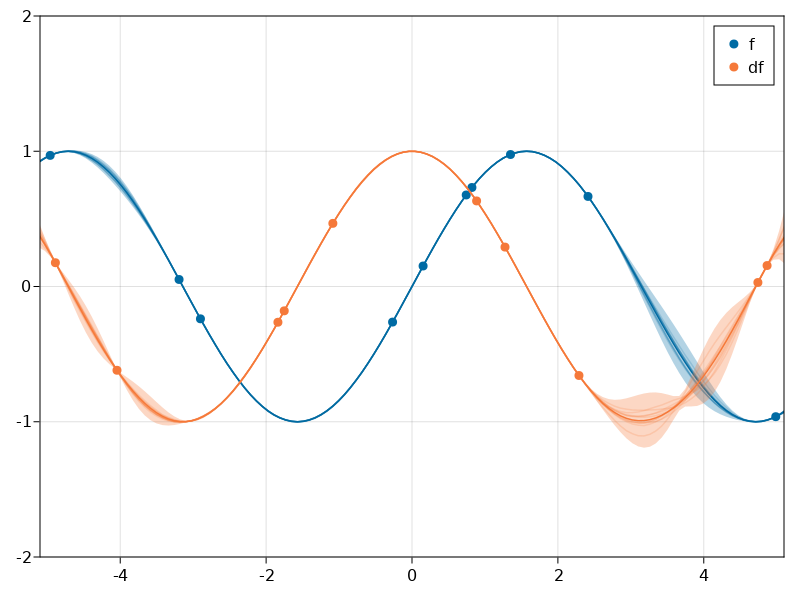

In [2]:
using CairoMakie: RGB

function colours()
    return Dict(
        :blue => RGB(0/255, 107/255, 164/255),
        :cyan => RGB(75/255, 166/255, 251/255),
        :red => RGB(200/255, 82 / 255, 0 / 255),
        :pink => RGB(169/255, 90/255, 161/255),
        :black => RGB(0.0, 0.0, 0.0),
        :orange => RGB(245/255, 121/255, 58/255),
    )
end

band_alpha() = 0.3
sample_alpha() = 0.2
point_alpha() = 1.0

let
    # Simple two-component model.
    f = @gppp let
        f = GP(SEKernel())
        df = derivative(f)
    end

    # Specify inputs at which to make observations.
    rng = MersenneTwister(123456)
    x_f = GPPPInput(:f, rand(rng, Uniform(-5.0, 5.0), 10))
    x_df = GPPPInput(:df, rand(rng, Uniform(-5.0, 5.0), 10))
    x = BlockData(x_f, x_df)

    # Build observations from simple functions.
    y_f = map(sin, x_f.x)
    y_df = map(cos, x_df.x)
    y = vcat(y_f, y_df)

    # Build posterior and visualise it.
    f_post = posterior(f(x, 1e-12), y)
    x_plot = collect(range(-6.0, 6.0; length=150))

    fig = Figure()
    ax = Axis(fig[1, 1])
    xlims = (-5.1, 5.1)
    ylims = (-2, 2)

    let
        f_xf = f_post(GPPPInput(:f, x_plot), 1e-6)
        ms = marginals(f_xf)
        symband!(
            ax, x_plot, mean.(ms), std.(ms);
            bandscale=3, color=(colours()[:blue], band_alpha()),
        )
        gpsample!(
            ax, x_plot, f_xf;
            samples=10, color=(colours()[:blue], sample_alpha()),
        )
        scatter!(ax, x_f.x, y_f; color=(colours()[:blue], point_alpha()), label="f")
    end

    let
        f_xdf = f_post(GPPPInput(:df, x_plot), 1e-6)
        ms = marginals(f_xdf)
        symband!(
            ax, x_plot, mean.(ms), std.(ms);
            bandscale=3, color=(colours()[:orange], band_alpha()),
        )
        gpsample!(
            ax, x_plot, f_xdf;
            samples=10, color=(colours()[:orange], sample_alpha()),
        )
        scatter!(ax, x_df.x, y_df; color=(colours()[:orange], point_alpha()), label="df")
    end

    axislegend(ax; position=:rt)
    xlims!(ax, xlims)
    ylims!(ax, ylims)

    fig
end

## Example: Integration via Antiderivatives

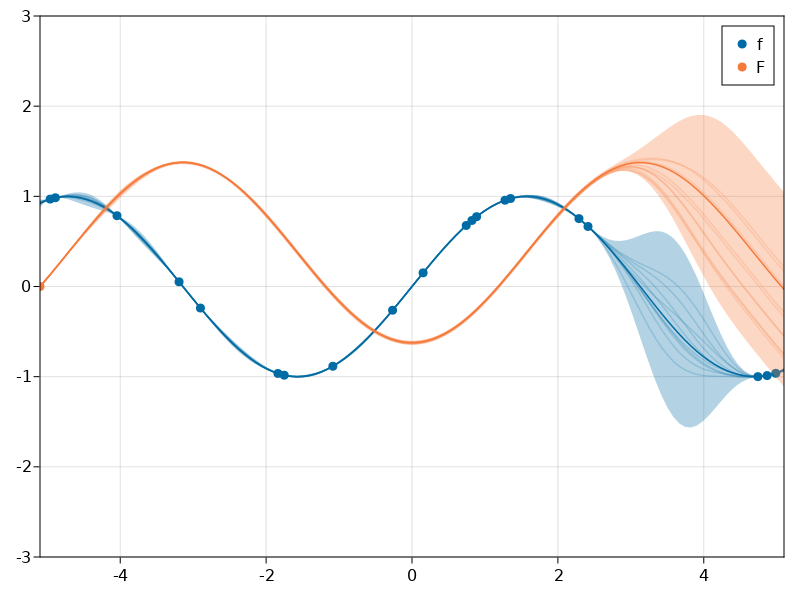

In [3]:
let
    # Build a model in which we place a prior over the integral, and differentiate it
    # to obtain the process of which to compute the integral.
    f = @gppp let
        F = GP(SEKernel())
        f = derivative(F)
    end

    # Build inputs. Integrate from -5.1.
    rng = MersenneTwister(123456)
    x_F = GPPPInput(:F, [-5.1])
    x_f = GPPPInput(:f, rand(rng, Uniform(-5.0, 5.0), 20))
    x = BlockData(x_F, x_f)

    # Build observations from simple functions. We know that the integral is 0 at -5.1.
    y_F = [0.0]
    y_f = map(sin, x_f.x)
    y = vcat(y_F, y_f)

    # Build posterior and visualise it.
    f_post = posterior(f(x, 1e-6), y)
    x_plot = collect(range(-6.0, 6.0; length=150))

    fig = Figure()
    ax = Axis(fig[1, 1])
    xlims = (-5.1, 5.1)
    ylims = (-3, 3)

    let
        f_xf = f_post(GPPPInput(:f, x_plot), 1e-6)
        ms = marginals(f_xf)
        symband!(
            ax, x_plot, mean.(ms), std.(ms);
            bandscale=3, color=(colours()[:blue], band_alpha()),
        )
        gpsample!(
            ax, x_plot, f_xf;
            samples=10, color=(colours()[:blue], sample_alpha()),
        )
        scatter!(ax, x_f.x, y_f; color=(colours()[:blue], point_alpha()), label="f")
    end

    let
        f_xdf = f_post(GPPPInput(:F, x_plot), 1e-6)
        ms = marginals(f_xdf)
        symband!(
            ax, x_plot, mean.(ms), std.(ms);
            bandscale=3, color=(colours()[:orange], band_alpha()),
        )
        gpsample!(
            ax, x_plot, f_xdf;
            samples=10, color=(colours()[:orange], sample_alpha()),
        )
        scatter!(ax, x_F.x, y_F; color=(colours()[:orange], point_alpha()), label="F")
    end

    axislegend(ax; position=:rt)
    xlims!(ax, xlims)
    ylims!(ax, ylims)

    fig
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*